In [1]:
from matplotlib import pyplot as plt
import pandas as pd
import random
import time
import math
import d2l
import os

from mxnet import autograd, np, npx, gluon, init, image
from mxnet.gluon import loss as gloss
from mxnet.gluon import nn
npx.set_np()

# 13. Computer Vision
Many applications in the area of computer vision are closely related to our daily lives, now and in the future, whether medical diagnostics, driverless vehicles, camera monitoring, or smart filters. In recent years, deep learning technology has greatly enhanced computer vision systems' performance. It can be said that the most advanced computer vision applications are nearly inseparable from deep learning.

We have introduced deep learning models commonly used in the area of computer vision in the chapter "Convolutional Neural Networks" and have practiced simple image classification tasks. In this chapter, we will introduce image augmentation and fine tuning methods and apply them to image classification. Then, we will explore various methods of object detection. After that, we will learn how to use fully convolutional networks to perform semantic segmentation on images. Then, we explain how to use style transfer technology to generate images that look like the cover of this book. Finally, we will perform practice exercises on two important computer vision datasets to review the content of this chapter and the previous chapters.

## 13.6 The Object Detection Dataset
There are no small datasets, like `MNIST` or `Fashion-MNIST`, in the object detection field. In order to quickly test models, we are going to assemble a small dataset. First, we generate 1000 Pikachu images of different angles and sizes using an open source 3D Pikachu model. Then, we collect a series of background images and place a Pikachu image at a random position on each image. We use the `im2rec` tool provided by `MXNet` to convert the images to binary `RecordIO` format. This format can reduce the storage overhead of the dataset on the disk and improve the reading efficiency. If you want to learn more about how to read images, refer to the documentation for the `GluonCV Toolkit`.

### 13.6.1 Downloading the Dataset
The Pikachu dataset in RecordIO format can be downloaded directly from the Internet.

In [2]:
d2l.DATA_HUB['pikachu'] = (d2l.DATA_URL+'pikachu.zip', '68ab1bd42143c5966785eb0d7b2839df8d570190')

### 13.6.2 Reading the Dataset
We are going to read the object detection dataset by creating the instance `ImageDetIter`. The `Det` in the name refers to `Detection`. We will read the training dataset in random order. Since the format of the dataset is `RecordIO`, we need the image index file `train.idx` to read random minibatches. In addition, for each image of the training set, we will use random cropping and require the cropped image to cover at least `95%` of each object. Since the cropping is random, this requirement is not always satisfied. We preset the maximum number of random cropping attempts to 200. If none of them meets the requirement, the image will not be cropped. To ensure the certainty of the output, we will not randomly crop the images in the test dataset. We also do not need to read the test dataset in random order.

In [3]:
#@save
def load_data_pikachu(batch_size, edge_size=256):
    """Load the pikachu dataset."""
    data_dir = d2l.download_extract('pikachu')
    train_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'train.rec'),
        path_imgidx=os.path.join(data_dir, 'train.idx'),
        batch_size=batch_size,
        data_shape=(3, edge_size, edge_size),  # The shape of the output image
        shuffle=True,  # Read the dataset in random order
        rand_crop=1,  # The probability of random cropping is 1
        min_object_covered=0.95, max_attempts=200)
    val_iter = image.ImageDetIter(
        path_imgrec=os.path.join(data_dir, 'val.rec'), batch_size=batch_size,
        data_shape=(3, edge_size, edge_size), shuffle=False)
    return train_iter, val_iter

Below, we read a minibatch and print the shape of the image and label. The shape of the image is the same as in the previous experiment `(batch size, number of channels, height, width)`. The shape of the label is `(batch size, m, 5)`, where $m$ is equal to the maximum number of bounding boxes contained in a single image in the dataset. Although computation for the minibatch is very efficient, it requires each image to contain the same number of bounding boxes so that they can be placed in the same batch. Since each image may have a different number of bounding boxes, we can add illegal bounding boxes to images that have less than $m$ bounding boxes until each image contains $m$ bounding boxes. Thus, we can read a minibatch of images each time. The label of each bounding box in the image is represented by an array of length 5. The first element in the array is the category of the object contained in the bounding box. When the value is -1, the bounding box is an illegal bounding box for filling purpose. The remaining four elements of the array represent the $x, y$ axis coordinates of the upper-left corner of the bounding box and the $x, y$ axis coordinates of the lower-right corner of the bounding box (the value range is between 0 and 1). The Pikachu dataset here has only one bounding box per image, so $m=1$.

In [4]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_pikachu(batch_size, edge_size)
batch = train_iter.next()
batch.data[0].shape, batch.label[0].shape

((32, 3, 256, 256), (32, 1, 5))

### 13.6.3 Demonstration
We have ten images with bounding boxes on them. We can see that the angle, size, and position of Pikachu are different in each image. Of course, this is a simple artificial dataset. In actual practice, the data are usually much more complicated.

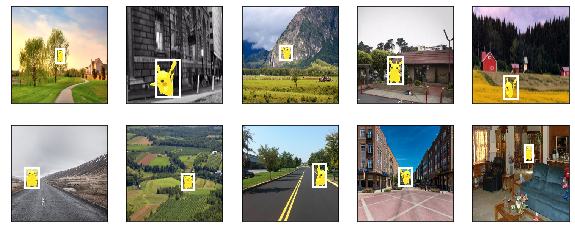

In [5]:
imgs = (batch.data[0][0:10].transpose(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch.label[0][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])

##### Summary
+ The Pikachu dataset we synthesized can be used to test object detection models.
+ The data reading for object detection is similar to that for image classification. However, after we introduce bounding boxes, the label shape and image augmentation (e.g., random cropping) are changed.

##### Exercises
1. Referring to the `MXNet` documentation, what are the parameters for the constructors of the `image.ImageDetIter` and `image.CreateDetAugmenter` classes? What is their significance?


## 13.7 Single Shot Multibox Detection (SSD)
In the previous few sections, we have introduced bounding boxes, anchor boxes, multiscale object detection, and datasets. Now, we will use this background knowledge to construct an object detection model: single shot multibox detection (SSD) (`Liu et al., 2016`). This quick and easy model is already widely used. Some of the design concepts and implementation details of this model are also applicable to other object detection models.

### 13.7.1 Model
`Fig. 13.7.1` shows the design of an SSD model. The model's main components are a base network block and several multiscale feature blocks connected in a series. Here, the base network block is used to extract features of original images, and it generally takes the form of a deep convolutional neural network. The paper on SSDs chooses to place a truncated `VGG` before the classification layer (`Liu et al., 2016`), but this is now commonly replaced by `ResNet`. We can design the base network so that it outputs larger heights and widths. In this way, more anchor boxes are generated based on this feature map, allowing us to detect smaller objects. Next, each multiscale feature block reduces the height and width of the feature map provided by the previous layer (for example, it may reduce the sizes by half). The blocks then use each element in the feature map to expand the receptive field on the input image. In this way, the closer a multiscale feature block is to the top of `Fig. 13.7.1` the smaller its output feature map, and the fewer the anchor boxes that are generated based on the feature map. In addition, the closer a feature block is to the top, the larger the receptive field of each element in the feature map and the better suited it is to detect larger objects. As the SSD generates different numbers of anchor boxes of different sizes based on the base network block and each multiscale feature block and then predicts the categories and offsets (i.e., predicted bounding boxes) of the anchor boxes in order to detect objects of different sizes, SSD is a multiscale object detection model.

<img src="images/13_04.png" style="width:600px;"/>

Next, we will describe the implementation of the modules in `Fig. 13.7.1`. First, we need to discuss the implementation of category prediction and bounding box prediction.

##### Category Prediction Layer
Set the number of object categories to $q$. In this case, the number of anchor box categories is $q+1$, with 0 indicating an anchor box that only contains background. For a certain scale, set the height and width of the feature map to $h$ and $w$, respectively. If we use each element as the center to generate $a$ anchor boxes, we need to classify a total of $hwa$ anchor boxes. If we use a fully connected layer (FCN) for the output, this will likely result in an excessive number of model parameters. Recall how we used convolutional layer channels to output category predictions in `Section 7.3`. SSD uses the same method to reduce the model complexity.

Specifically, the category prediction layer uses a convolutional layer that maintains the input height and width. Thus, the output and input have a one-to-one correspondence to the spatial coordinates along the width and height of the feature map. Assuming that the output and input have the same spatial coordinates $(x, y)$, the channel for the coordinates $(x, y)$ on the output feature map contains the category predictions for all anchor boxes generated using the input feature map coordinates $(x, y)$ as the center. Therefore, there are $a(q+1)$ output channels, with the output channels indexed as $i(q+1) + j$ ($0 \leq j \leq q$) representing the predictions of the category index $j$ for the anchor box index $i$.

Now, we will define a category prediction layer of this type. After we specify the parameters $a$ and $q$, it uses a $3\times3$ convolutional layer with a padding of 1. The heights and widths of the input and output of this convolutional layer remain unchanged.

In [6]:
def cls_predictor(num_anchors, num_classes):
    return nn.Conv2D(num_anchors * (num_classes + 1), kernel_size=3, padding=1)

##### Bounding Box Prediction Layer
The design of the bounding box prediction layer is similar to that of the category prediction layer. The only difference is that, here, we need to predict 4 offsets for each anchor box, rather than $q+1$ categories.

In [7]:
def bbox_predictor(num_anchors):
    return nn.Conv2D(num_anchors * 4, kernel_size=3, padding=1)

##### Concatenating Predictions for Multiple Scales
As we mentioned, SSD uses feature maps based on multiple scales to generate anchor boxes and predict their categories and offsets. Because the shapes and number of anchor boxes centered on the same element differ for the feature maps of different scales, the prediction outputs at different scales may have different shapes.

In the following example, we use the same batch of data to construct feature maps of two different scales, `Y1` and `Y2`. Here, `Y2` has half the height and half the width of `Y1`. Using category prediction as an example, we assume that each element in the `Y1` and `Y2` feature maps generates five (`Y1`) or three (`Y2`) anchor boxes. When there are 10 object categories, the number of category prediction output channels is either $5\times(10+1)=55$ or $3\times(10+1)=33$. The format of the prediction output is `(batch size, number of channels, height, width)`. As you can see, except for the batch size, the sizes of the other dimensions are different. Therefore, we must transform them into a consistent format and concatenate the predictions of the multiple scales to facilitate subsequent computation.

In [8]:
def forward(x, block):
    block.initialize()
    return block(x)

Y1 = forward(np.zeros((2, 8, 20, 20)), cls_predictor(5, 10))
Y2 = forward(np.zeros((2, 16, 10, 10)), cls_predictor(3, 10))
(Y1.shape, Y2.shape)

((2, 55, 20, 20), (2, 33, 10, 10))

The channel dimension contains the predictions for all anchor boxes with the same center. We first move the channel dimension to the final dimension. Because the batch size is the same for all scales, we can convert the prediction results to binary format `(batch size, height * width * number_of_channels) to facilitate subsequent concatenation on the $1^{\mathrm{st}}$ dimension.

In [9]:
def flatten_pred(pred):
    return npx.batch_flatten(pred.transpose(0, 2, 3, 1))

def concat_preds(preds):
    return np.concatenate([flatten_pred(p) for p in preds], axis=1)

Thus, regardless of the different shapes of `Y1` and `Y2`, we can still concatenate the prediction results for the two different scales of the same batch.

In [10]:
concat_preds([Y1, Y2]).shape

(2, 25300)

##### Height and Width Downsample Block
For multiscale object detection, we define the following `down_sample_blk` block, which reduces the height and width by `50%`. This block consists of two $3\times3$ convolutional layers with a padding of 1 and a $2\times2$ maximum pooling layer with a stride of 2 connected in a series. As we know, $3\times3$ convolutional layers with a padding of 1 do not change the shape of feature maps. However, the subsequent pooling layer directly reduces the size of the feature map by half. Because $1\times 2+(3-1)+(3-1)=6$, each element in the output feature map has a receptive field on the input feature map of the shape $6\times6$. As you can see, the height and width downsample block enlarges the receptive field of each element in the output feature map.

In [11]:
def down_sample_blk(num_channels):
    blk = nn.Sequential()
    for _ in range(2):
        blk.add(nn.Conv2D(num_channels, kernel_size=3, padding=1),
                nn.BatchNorm(in_channels=num_channels),
                nn.Activation('relu'))
    blk.add(nn.MaxPool2D(2))
    return blk

By testing forward computation in the height and width downsample block, we can see that it changes the number of input channels and halves the height and width.

In [12]:
forward(np.zeros((2, 3, 20, 20)), down_sample_blk(10)).shape

(2, 10, 10, 10)

##### Base Network Block
The base network block is used to extract features from original images. To simplify the computation, we will construct a small base network. This network consists of three height and width downsample blocks connected in a series, so it doubles the number of channels at each step. When we input an original image with the shape $256\times256$, the base network block outputs a feature map with the shape $32 \times 32$.

In [13]:
def base_net():
    blk = nn.Sequential()
    for num_filters in [16, 32, 64]:
        blk.add(down_sample_blk(num_filters))
    return blk

forward(np.zeros((2, 3, 256, 256)), base_net()).shape

(2, 64, 32, 32)

##### The Complete Model
The SSD model contains a total of five modules. Each module outputs a feature map used to generate anchor boxes and predict the categories and offsets of these anchor boxes. The first module is the base network block, modules two to four are height and width downsample blocks, and the fifth module is a global maximum pooling layer that reduces the height and width to 1. Therefore, modules two to five are all multiscale feature blocks shown in `Fig. 13.7.1`.

In [14]:
def get_blk(i):
    if i == 0:
        blk = base_net()
    elif i == 4:
        blk = nn.GlobalMaxPool2D()
    else:
        blk = down_sample_blk(128)
    return blk

Now, we will define the forward computation process for each module. In contrast to the previously-described convolutional neural networks, this module not only returns feature map `Y` output by convolutional computation, but also the anchor boxes of the current scale generated from `Y` and their predicted categories and offsets.

In [15]:
def blk_forward(X, blk, size, ratio, cls_predictor, bbox_predictor):
    Y = blk(X)
    anchors = npx.multibox_prior(Y, sizes=size, ratios=ratio)
    cls_preds = cls_predictor(Y)
    bbox_preds = bbox_predictor(Y)
    return (Y, anchors, cls_preds, bbox_preds)

As we mentioned, the closer a multiscale feature block is to the top in `Fig. 13.7.1`, the larger the objects it detects and the larger the anchor boxes it must generate. Here, we first divide the interval from 0.2 to 1.05 into five equal parts to determine the sizes of smaller anchor boxes at different scales: 0.2, 0.37, 0.54, etc. Then, according to $\sqrt{0.2 \times 0.37} = 0.272$, $\sqrt{0.37 \times 0.54} = 0.447$, and similar formulas, we determine the sizes of larger anchor boxes at the different scales.

In [16]:
sizes = [[0.2, 0.272], [0.37, 0.447], [0.54, 0.619], [0.71, 0.79], [0.88, 0.961]]
ratios = [[1, 2, 0.5]] * 5
num_anchors = len(sizes[0]) + len(ratios[0]) - 1

Now, we can define the complete model, `TinySSD`.

In [17]:
class TinySSD(nn.Block):
    def __init__(self, num_classes, **kwargs):
        super(TinySSD, self).__init__(**kwargs)
        self.num_classes = num_classes
        for i in range(5):
            # The assignment statement is self.blk_i = get_blk(i)
            setattr(self, f'blk_{i}', get_blk(i))
            setattr(self, f'cls_{i}', cls_predictor(num_anchors, num_classes))
            setattr(self, f'bbox_{i}', bbox_predictor(num_anchors))

    def forward(self, X):
        anchors, cls_preds, bbox_preds = [None] * 5, [None] * 5, [None] * 5
        for i in range(5):
            # getattr(self, 'blk_%d' % i) accesses self.blk_i
            X, anchors[i], cls_preds[i], bbox_preds[i] = blk_forward(
                X, getattr(self, f'blk_{i}'), sizes[i], ratios[i],
                getattr(self, f'cls_{i}'), getattr(self, f'bbox_{i}'))
        # In the reshape function, 0 indicates that the batch size remains
        # unchanged
        anchors = np.concatenate(anchors, axis=1)
        cls_preds = concat_preds(cls_preds)
        cls_preds = cls_preds.reshape(cls_preds.shape[0], -1, self.num_classes + 1)
        bbox_preds = concat_preds(bbox_preds)
        return anchors, cls_preds, bbox_preds

We now create an SSD model instance and use it to perform forward computation on image minibatch `X`, which has a height and width of 256 pixels. As we verified previously, the first module outputs a feature map with the shape $32 \times 32$. Because modules two to four are height and width downsample blocks, module five is a global pooling layer, and each element in the feature map is used as the center for 4 anchor boxes, a total of $(32^2 + 16^2 + 8^2 + 4^2 + 1)\times 4 = 5444$ anchor boxes are generated for each image at the five scales.

In [18]:
net = TinySSD(num_classes=1)
net.initialize()
X = np.zeros((32, 3, 256, 256))
anchors, cls_preds, bbox_preds = net(X)

print('output anchors:', anchors.shape)
print('output class preds:', cls_preds.shape)
print('output bbox preds:', bbox_preds.shape)

output anchors: (1, 5444, 4)
output class preds: (32, 5444, 2)
output bbox preds: (32, 21776)


### 13.7.2 Training
Now, we will explain, step by step, how to train the SSD model for object detection.

##### Data Reading and Initialization
We read the Pikachu dataset we created in the previous section.

In [19]:
batch_size = 20
train_iter, _ = d2l.load_data_pikachu(batch_size)

There is 1 category in the Pikachu dataset. After defining the module, we need to initialize the model parameters and define the optimization algorithm.

In [20]:
ctx, net = d2l.try_gpu(), TinySSD(num_classes=1)
net.initialize(init=init.Xavier(), ctx=ctx)
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.2, 'wd': 5e-4})

##### Defining Loss and Evaluation Functions
Object detection is subject to two types of losses. The first is anchor box category loss. For this, we can simply reuse the cross-entropy loss function we used in image classification. The second loss is positive anchor box offset loss. Offset prediction is a normalization problem. However, here, we do not use the squared loss introduced previously. Rather, we use the $L_1$ norm loss, which is the absolute value of the difference between the predicted value and the ground-truth value. The mask variable `bbox_masks` removes negative anchor boxes and padding anchor boxes from the loss calculation. Finally, we add the anchor box category and offset losses to find the final loss function for the model.

In [21]:
cls_loss = gluon.loss.SoftmaxCrossEntropyLoss()
bbox_loss = gluon.loss.L1Loss()

def calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks):
    cls = cls_loss(cls_preds, cls_labels)
    bbox = bbox_loss(bbox_preds * bbox_masks, bbox_labels * bbox_masks)
    return cls + bbox

We can use the accuracy rate to evaluate the classification results. As we use the $L_1$ norm loss, we will use the average absolute error to evaluate the bounding box prediction results.

In [22]:
def cls_eval(cls_preds, cls_labels):
    # Because the category prediction results are placed in the final
    # dimension, argmax must specify this dimension
    return float((cls_preds.argmax(axis=-1) == cls_labels).sum())

def bbox_eval(bbox_preds, bbox_labels, bbox_masks):
    return float((np.abs((bbox_labels - bbox_preds) * bbox_masks)).sum())

##### Training the Model
During model training, we must generate multiscale anchor boxes (`anchors`) in the model's forward computation process and predict the category (`cls_preds`) and offset (`bbox_preds`) for each anchor box. Afterwards, we label the category (`cls_labels`) and offset (`bbox_labels`) of each generated anchor box based on the label information Y. Finally, we calculate the loss function using the predicted and labeled category and offset values. To simplify the code, we do not evaluate the training dataset here.

class err 2.27e-03, bbox mae 2.44e-03
1800.9 examples/sec on gpu(0)


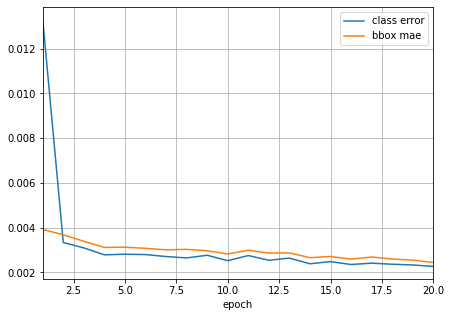

In [23]:
num_epochs, timer = 20, d2l.Timer()
animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], legend=['class error', 'bbox mae'])
for epoch in range(num_epochs):
    # accuracy_sum, mae_sum, num_examples, num_labels
    metric = d2l.Accumulator(4)
    train_iter.reset()  # Read data from the start.
    for batch in train_iter:
        timer.start()
        X = batch.data[0].as_in_ctx(ctx)
        Y = batch.label[0].as_in_ctx(ctx)
        with autograd.record():
            # Generate multiscale anchor boxes and predict the category and offset of each
            anchors, cls_preds, bbox_preds = net(X)
            # Label the category and offset of each anchor box
            bbox_labels, bbox_masks, cls_labels = npx.multibox_target(
                anchors, Y, cls_preds.transpose(0, 2, 1))
            # Calculate the loss function using the predicted and labeled category and offset values
            l = calc_loss(cls_preds, cls_labels, bbox_preds, bbox_labels, bbox_masks)
        l.backward()
        trainer.step(batch_size)
        metric.add(cls_eval(cls_preds, cls_labels), cls_labels.size,
                   bbox_eval(bbox_preds, bbox_labels, bbox_masks),
                   bbox_labels.size)
    cls_err, bbox_mae = 1-metric[0]/metric[1], metric[2]/metric[3]
    animator.add(epoch+1, (cls_err, bbox_mae))
print(f'class err {cls_err:.2e}, bbox mae {bbox_mae:.2e}')
print(f'{train_iter.num_image/timer.stop():.1f} examples/sec on {str(ctx)}')

### 13.7.3 Prediction
In the prediction stage, we want to detect all objects of interest in the image. Below, we read the test image and transform its size. Then, we convert it to the four-dimensional format required by the convolutional layer.

In [24]:
img = image.imread('./images/pikachu.jpg')
feature = image.imresize(img, 256, 256).astype('float32')
X = np.expand_dims(feature.transpose(2, 0, 1), axis=0)

Using the `MultiBoxDetection` function, we predict the bounding boxes based on the anchor boxes and their predicted offsets. Then, we use non-maximum suppression to remove similar bounding boxes.

In [25]:
def predict(X):
    anchors, cls_preds, bbox_preds = net(X.as_in_ctx(ctx))
    cls_probs = npx.softmax(cls_preds).transpose(0, 2, 1)
    output = npx.multibox_detection(cls_probs, bbox_preds, anchors)
    idx = [i for i, row in enumerate(output[0]) if row[0] != -1]
    return output[0, idx]

output = predict(X)

Finally, we take all the bounding boxes with a confidence level of at least 0.3 and display them as the final output.

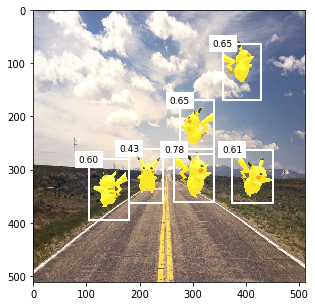

In [26]:
def display(img, output, threshold):
    d2l.set_figsize((5, 5))
    fig = d2l.plt.imshow(img.asnumpy())
    for row in output:
        score = float(row[1])
        if score < threshold:
            continue
        h, w = img.shape[0:2]
        bbox = [row[2:6] * np.array((w, h, w, h), ctx=row.ctx)]
        d2l.show_bboxes(fig.axes, bbox, '%.2f' % score, 'w')

display(img, output, threshold=0.3)

##### Summary
+ SSD is a multiscale object detection model. This model generates different numbers of anchor boxes of different sizes based on the base network block and each multiscale feature block and predicts the categories and offsets of the anchor boxes to detect objects of different sizes.
+ During SSD model training, the loss function is calculated using the predicted and labeled category and offset values.

##### Exercises
1. Due to space limitations, we have ignored some of the implementation details of SSD models in this experiment. Can you further improve the model in the following areas?

***Loss Function***
For the predicted offsets, replace $L_1$ norm loss with $L_1$ regularization loss. This loss function uses a square function around zero for greater smoothness. This is the regularized area controlled by the hyperparameter $\sigma$:

$$ f(x) = \begin{cases} (\sigma x)^2/2,& \text{if }|x| < 1/\sigma^2\\ |x|-0.5/\sigma^2,& \text{otherwise} \end{cases} $$

When $\sigma$ is large, this loss is similar to the $L_1$ norm loss. When the value is small, the loss function is smoother.

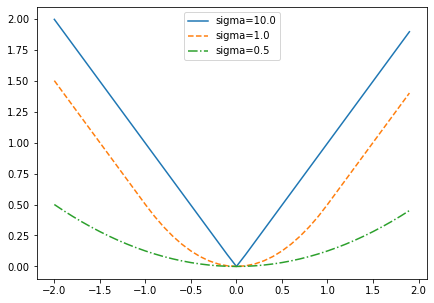

In [27]:
sigmas = [10, 1, 0.5]
lines = ['-', '--', '-.']
x = np.arange(-2, 2, 0.1)
d2l.set_figsize()

for l, s in zip(lines, sigmas):
    y = npx.smooth_l1(x, scalar=s)
    d2l.plt.plot(x.asnumpy(), y.asnumpy(), l, label='sigma=%.1f' % s)
d2l.plt.legend();

In the experiment, we used cross-entropy loss for category prediction. Now, assume that the prediction probability of the actual category $j$ is $p_j$ and the cross-entropy loss is $-\log p_j$. We can also use the focal loss (`Lin et al., 2017`). Given the positive hyperparameters $\gamma$ and $\alpha$, this loss is defined as:

$$ - \alpha (1-p_j)^{\gamma} \log p_j.$$

As you can see, by increasing $\gamma$, we can effectively reduce the loss when the probability of predicting the correct category is high.

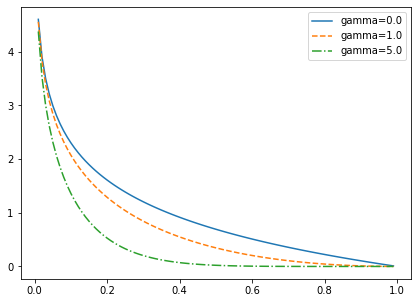

In [28]:
def focal_loss(gamma, x):
    return -(1 - x) ** gamma * np.log(x)

x = np.arange(0.01, 1, 0.01)
for l, gamma in zip(lines, [0, 1, 5]):
    y = d2l.plt.plot(x.asnumpy(), focal_loss(gamma, x).asnumpy(), l,
                     label='gamma=%.1f' % gamma)
d2l.plt.legend();

2. When an object is relatively large compared to the image, the model normally adopts a larger input image size.
3. This generally produces a large number of negative anchor boxes when labeling anchor box categories. We can sample the negative anchor boxes to better balance the data categories. To do this, we can set the MultiBoxTarget function's negative_mining_ratio parameter.
4. Assign hyperparameters with different weights to the anchor box category loss and positive anchor box offset loss in the loss function.
5. Refer to the SSD paper. What methods can be used to evaluate the precision of object detection models (`Liu et al., 2016`)?


## 13.8 Region-based CNNs (R-CNNs)
`Region-based convolutional neural networks` or `regions with CNN features` (`R-CNNs`) are a pioneering approach that applies deep models to object detection (`Girshick et al., 2014`). In this section, we will discuss `R-CNNs` and a series of improvements made to them: `Fast R-CNN` (`Girshick,2015`), `Faster R-CNN` (`Ren et al., 2015`), and `Mask R-CNN` (`He et al., 2017a`). Due to space limitations, we will confine our discussion to the designs of these models.

### 13.8.1 R-CNNs
`R-CNN` models first select several proposed regions from an image (for example, anchor boxes are one type of selection method) and then label their categories and bounding boxes (e.g., offsets). Then, they use a CNN to perform forward computation to extract features from each proposed area. Afterwards, we use the features of each proposed region to predict their categories and bounding boxes. `Fig. 13.8.1` shows an R-CNN model.

<img src="images/13_05.png" style="width:600px;"/>

Specifically, `R-CNNs` are composed of four main parts:
1. Selective search is performed on the input image to select multiple high-quality proposed regions (`Uijlings et al., 2013`). These proposed regions are generally selected on multiple scales and have different shapes and sizes. The category and ground-truth bounding box of each proposed region is labeled.
2. A `pre-trained CNN` is selected and placed, in truncated form, before the output layer. It transforms each proposed region into the input dimensions required by the network and uses forward computation to output the features extracted from the proposed regions.
3. The features and labeled category of each proposed region are combined as an example to train multiple support vector machines for object classification. Here, each support vector machine is used to determine whether an example belongs to a certain category.
4. The features and labeled bounding box of each proposed region are combined as an example to train a linear regression model for ground-truth bounding box prediction.

Although `R-CNN` models use `pre-trained CNNs` to effectively extract image features, the main downside is the slow speed. As you can imagine, we can select thousands of proposed regions from a single image, requiring thousands of forward computations from the `CNN` to perform object detection. This massive computing load means that `R-CNNs` are not widely used in actual applications.

### 13.8.2 Fast R-CNN
The main performance bottleneck of an `R-CNN` model is the need to independently extract features for each proposed region. As these regions have a high degree of overlap, independent feature extraction results in a high volume of repetitive computations. `Fast R-CNN` improves on the `R-CNN` by only performing `CNN` forward computation on the image as a whole.

<img src="images/13_06.png" style="width:300px;"/>

`Fig. 13.8.2` shows a `Fast R-CNN` model. It is primary computation steps are described below:
1. Compared to an `R-CNN` model, a `Fast R-CNN` model uses the entire image as the `CNN` input for feature extraction, rather than each proposed region. Moreover, this network is generally trained to update the model parameters. As the input is an entire image, the `CNN` output shape is $1 \times c \times h_1 \times w_1$.
2. Assuming selective search generates $n$ proposed regions, their different shapes indicate regions of interests (`RoIs`) of different shapes on the `CNN` output. Features of the same shapes must be extracted from these `RoIs` (here we assume that the height is $h_2$ and the width is $w_2$). `Fast R-CNN` introduces `RoI` pooling, which uses the `CNN` output and `RoIs` as input to output a concatenation of the features extracted from each proposed region with the shape $n \times c \times h_2 \times w_2$.
3. A fully connected layer is used to transform the output shape to $n \times d$, where $d$ is determined by the model design.
4. During category prediction, the shape of the fully connected layer output is again transformed to $n \times q$ and we use softmax regression ($q$ is the number of categories). During bounding box prediction, the shape of the fully connected layer output is again transformed to $n \times 4$. This means that we predict the category and bounding box for each proposed region.

The `RoI` pooling layer in `Fast R-CNN` is somewhat different from the pooling layers we have discussed before. In a normal pooling layer, we set the pooling window, padding, and stride to control the output shape. In an `RoI` pooling layer, we can directly specify the output shape of each region, such as specifying the height and width of each region as $h_2, w_2$. Assuming that the height and width of the RoI window are $h$ and $w$, this window is divided into a grid of sub-windows with the shape $h_2 \times w_2$. The size of each sub-window is about $(h/h_2) \times (w/w_2)$. The sub-window height and width must always be integers and the largest element is used as the output for a given sub-window. This allows the `RoI` pooling layer to extract features of the same shape from `RoIs` of different shapes.

In `Fig. 13.8.3`, we select an $3\times 3$ region as an `RoI` of the $4 \times 4$ input. For this `RoI`, we use a $2\times 2$ RoI pooling layer to obtain a single $2\times 2$ output. When we divide the region into four sub-windows, they respectively contain the elements 0, 1, 4, and 5 (5 is the largest); 2 and 6 (6 is the largest); 8 and 9 (9 is the largest); and 10.

<img src="images/13_07.png" style="width:350px;"/>

We use the `ROIPooling` function to demonstrate the `RoI` pooling layer computation. Assume that the `CNN` extracts the feature $X$ with both a height and width of 4 and only a single channel.

In [29]:
X = np.arange(16).reshape(1, 1, 4, 4)
X

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]]])

Assume that the height and width of the image are both 40 pixels and that selective search generates two proposed regions on the image. Each region is expressed as five elements: the region's object category and the $x, y$ coordinates of its upper-left and bottom-right corners.

In [30]:
rois = np.array([[0, 0, 0, 20, 20], [0, 0, 10, 30, 30]])

Because the height and width of X are $1/10$ of the height and width of the image, the coordinates of the two proposed regions are multiplied by 0.1 according to the spatial_scale, and then the RoIs are labeled on X as X[:, :, 0:3, 0:3] and X[:, :, 1:4, 0:4], respectively. Finally, we divide the two RoIs into a sub-window grid and extract features with a height and width of 2.

In [31]:
npx.roi_pooling(X, rois, pooled_size=(2, 2), spatial_scale=0.1)

array([[[[ 5.,  6.],
         [ 9., 10.]]],


       [[[ 9., 11.],
         [13., 15.]]]])

### 13.8.3 Faster R-CNN
In order to obtain precise object detection results, `Fast R-CNN` generally requires that many proposed regions be generated in selective search. `Faster R-CNN` replaces selective search with a region proposal network. This reduces the number of proposed regions generated, while ensuring precise object detection.

<img src="images/13_08.png" style="width:500px;"/>

`Fig. 13.8.4` shows a `Faster R-CNN` model. Compared to `Fast R-CNN`, `Faster R-CNN` only changes the method for generating proposed regions from selective search to region proposal network. The other parts of the model remain unchanged. The detailed region proposal network computation process is described below:
1. We use a $3\times 3$ convolutional layer with a padding of 1 to transform the CNN output and set the number of output channels to $c$. This way, each element in the feature map the CNN extracts from the image is a new feature with a length of $c$.
2. We use each element in the feature map as a center to generate multiple anchor boxes of different sizes and aspect ratios and then label them.
3. We use the features of the elements of length $c$ at the center on the anchor boxes to predict the binary category (object or background) and bounding box for their respective anchor boxes.
4. Then, we use non-maximum suppression to remove similar bounding box results that correspond to category predictions of "object". Finally, we output the predicted bounding boxes as the proposed regions required by the RoI pooling layer.

It is worth noting that, as a part of the `Faster R-CNN` model, the region proposal network is trained together with the rest of the model. In addition, the `Faster R-CNN` object functions include the category and bounding box predictions in object detection, as well as the binary category and bounding box predictions for the anchor boxes in the region proposal network. Finally, the region proposal network can learn how to generate high-quality proposed regions, which reduces the number of proposed regions while maintaining the precision of object detection.

### 13.8.4 Mask R-CNN
If training data is labeled with the pixel-level positions of each object in an image, a `Mask R-CNN` model can effectively use these detailed labels to further improve the precision of object detection.

<img src="images/13_09.png" style="width:400px;"/>

As shown in `Fig. 13.8.5`, `Mask R-CNN` is a modification to the `Faster R-CNN` model. `Mask R-CNN` models replace the `RoI` pooling layer with an `RoI` alignment layer. This allows the use of bilinear interpolation to retain spatial information on feature maps, making `Mask R-CNN` better suited for pixel-level predictions. The `RoI` alignment layer outputs feature maps of the same shape for all `RoIs`. This not only predicts the categories and bounding boxes of `RoIs`, but allows us to use an additional fully convolutional network to predict the pixel-level positions of objects. We will describe how to use fully convolutional networks to predict pixel-level semantics in images later in this chapter.

##### Summary
+ An `R-CNN` model selects several proposed regions and uses a `CNN` to perform forward computation and extract the features from each proposed region. It then uses these features to predict the categories and bounding boxes of proposed regions.
+ `Fast R-CNN` improves on the `R-CNN` by only performing `CNN` forward computation on the image as a whole. It introduces an `RoI` pooling layer to extract features of the same shape from `RoIs` of different shapes.
+ `Faster R-CNN` replaces the selective search used in `Fast R-CNN` with a region proposal network. This reduces the number of proposed regions generated, while ensuring precise object detection.
+ `Mask R-CNN` uses the same basic structure as `Faster R-CNN`, but adds a fully convolution layer to help locate objects at the pixel level and further improve the precision of object detection.

##### Exercises
1. Study the implementation of each model in the GluonCV toolkit related to this section.